In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../../', 'chatbot')))

In [2]:
from dotenv import load_dotenv, find_dotenv
from langchain_community.graphs import Neo4jGraph

load_dotenv(find_dotenv())
db = Neo4jGraph()

In [3]:
from langchain_openai import ChatOpenAI
from graph import calculate_risk_coefficients, car_analysis, go_to_searcher
from guardian import Guardian,  PictureAnalyzer
from query_generator import create_query_generator
from langgraph.prebuilt import ToolNode

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)
picture_analysis = PictureAnalyzer(llm).create_picture_analyzer()
query_gen = create_query_generator(llm, db)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (row) { ... }} {position: line: 1, column: 21, offset: 20} for query: "UNWIND $data AS row CALL { WITH row MERGE (c:`Chunk` {id: row.id}) WITH c, row CALL db.create.setNodeVectorProperty(c, 'embedding', row.embedding) SET c.`text` = row.text SET c += row.metadata } IN TRANSACTIONS OF 1000 ROWS "


In [4]:
guardian = Guardian(llm, [go_to_searcher])
llm_with_guardian = guardian.create_guardian()
search_node = ToolNode([go_to_searcher])

In [5]:
tool_node = ToolNode([calculate_risk_coefficients, car_analysis])

In [6]:
from caller import Caller

mini_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

caller = Caller(mini_llm, [calculate_risk_coefficients, car_analysis]).create_caller()

app_tools = {
    'db': db,
    'caller': caller,
    'guardian': llm_with_guardian,
    'cypher': query_gen,
    'picture': picture_analysis,
}

In [7]:
from graph import State, compile_graph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph

graph = StateGraph(State)
memory = MemorySaver()

app = compile_graph(graph, memory, search_node, tool_node)

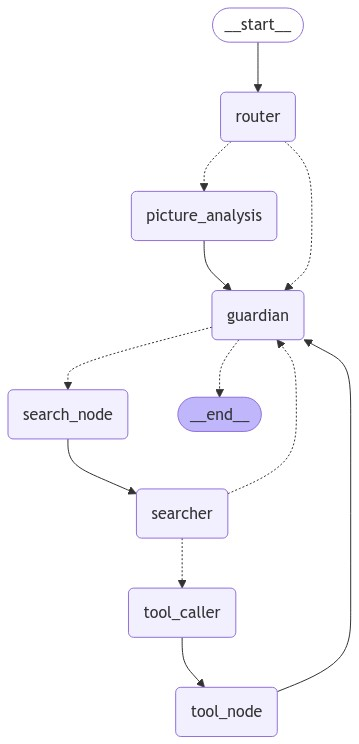

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

config = {"configurable": {"thread_id": "1"}, "recursion_limit": 15}
config['configurable'].update(app_tools)

In [11]:
user_input = "Parlami della moglie di Pio Tarquinio"

events = app.astream(
    {"messages": ("user", user_input), "is_picture": False}, config=config, stream_mode="values",
)
async for event in events:
    event["messages"][-1].pretty_print()
    final_message = event

================================ Human Message =================================

Parlami della moglie di Pio Tarquinio
================================ Human Message =================================

Parlami della moglie di Pio Tarquinio
================================== Ai Message ==================================
Tool Calls:
  go_to_searcher (call_ipVMqGa9kOfUVLf36u0vn8SI)
 Call ID: call_ipVMqGa9kOfUVLf36u0vn8SI
  Args:
    state: {'messages': [{'content': 'Parlami della moglie di Pio Tarquinio', 'type': 'human'}], 'data': None, 'is_picture': None}
================================= Tool Message =================================
Name: go_to_searcher

search
Searcher query: MATCH (p:Person {name: 'Pio', last_name: 'Tarquinio'})-[:PARTNER_OF]->(w:Person) RETURN w
================================== Ai Message ==================================

[{'w': {'cf': 'TCECRL95T18H501W', 'birthdate': '1995-12-18', 'gender': 'F', 'birthplace': 'ROMA', 'name': 'Carla', 'last_name': 'Teci', 'resi

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n    MATCH (p:Person {cf: 'TCECRL95T18H501W'})\n    OPTIONAL MATCH (p)-[:HAS_COMMITTED]->(c:Crime)\n    OPTIONAL MATCH (p)-[:PARTNER_OF]->(p1:Person)-[:HAS_COMMITTED]->(c1:Crime)\n    OPTIONAL MATCH (p)-[:CHILD_OF]->(p2:Person)-[:HAS_COMMITTED]->(c2:Crime)\n    OPTIONAL MATCH (p)<-[:CHILD_OF]-(p3:Person)-[:HAS_COMMITTED]->(c3:Crime)\n    OPTIONAL MATCH (p)-[:WORK_AT]->(w:Workplace)<-[:WORK_AT]-(p4:Person)-[:HAS_COMMITTED]->(c4:Crime)\n    OPTIONAL MATCH (p)-[:CHILD_OF]->(p2:Person)<-[:CHILD_OF]-(sibling:Person)-[:HAS_COMMITTED]->(c5:Crime)\n    RETURN \n        COALESCE(SUM(DISTINCT c.severity_score), 0) AS score_reati_diretti, \n        COALESCE(SUM(DISTINCT c1.severity_score), 0) 

================================= Tool Message =================================
Name: calculate_risk_coefficients

{"score_reati_diretti": 0, "score_reati_partner": 0, "score_reati_genitori": 0, "score_reati_figli": 0, "score_reati_colleghi": 1020, "score_reati_fratelli": 0, "score_ponderato": 51.0}
================================== Ai Message ==================================

Ecco le informazioni disponibili su Carla Teci, moglie di Pio Tarquinio:

| Campo         | Dettaglio          |
|---------------|--------------------|
| Codice Fiscale| TCECRL95T18H501W   |
| Data di Nascita| 18 dicembre 1995   |
| Genere        | Femminile          |
| Luogo di Nascita| Roma             |
| Nome          | Carla              |
| Cognome       | Teci               |
| Residenza     | Bergamo            |

**Report:**
Carla Teci è nata a Roma il 18 dicembre 1995 e attualmente risiede a Bergamo.

**Coefficiente di Rischio di Carla Teci:**

| Categoria                | Punteggio |
|------------

In [10]:
image_url = "https://immagini.alvolante.it/sites/default/files/styles/anteprima_640/public/dasapere_galleria/2024/07/targa-italiana-987.jpg"
import httpx
import base64
image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
image = f"{image_data}"

In [ ]:
events = app.astream(
    {"messages": ("user", image), "is_picture": True}, config=config, stream_mode="values",
)
async for event in events:
    event["messages"][-1].pretty_print()
    final_message = event

In [ ]:
print(final_message["messages"][-1].content)

In [ ]:
snapshot = app.get_state(config).values
from pprint import pprint
pprint(snapshot)